<a href="https://colab.research.google.com/github/fadindashafira/TIAToolBox/blob/main/04_patch_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patch Extraction from Histology Image

We will use tiatoolbox to **extract patches** from a **large histology image**.

Tiatoolbox can extract patches in different ways, such as:

* Point-based
* Fixed-window
* Variable-window patch extraction

One practical use of these tools is when using deep learning models that **cannot accept large images** in the input. In particular, we will introduce the use of our module [patchextraction](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/tools/patchextraction.py)

## Setting up the environment

### TIAToolbox and dependencies installation



In [1]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install tiatoolbox | tail -n 1

print("Installation is done.")

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.30.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.


Installation is done.


### Importing related libraries

In [16]:
from tiatoolbox.tools import patchextraction # Defines patch extraction methods for DL models
from tiatoolbox.utils.misc import imread # read an image as numpy array
from tiatoolbox.utils.misc import read_locations # read annotations as pandas DataFrame

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300 #  for high resolution figure in noteboo, dpi = dots per inch
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

## Downloading the Required Files

We download over the internet, a couple of files:

* a histology image
* a csv file

containing the positions of nuclei in that image.

Note: Download is needed once in each Colab session.

In [17]:
import requests # to making http request to interact with websites

img_file_name = "sample_img.png"
csv_file_name = "sample_coordinates.csv"

# Downloading sample image from MoNuSeg
r = requests.get(
    "https://tiatoolbox.dcs.warwick.ac.uk/testdata/patchextraction/TCGA-HE-7130-01Z-00-DX1.png"
)

with open(img_file_name, "wb") as f:
  f.write(r.content)

# Downloading points list
r = requests.get(
  "https://tiatoolbox.dcs.warwick.ac.uk/testdata/patchextraction/sample_patch_extraction.csv"
)

with open(csv_file_name, "wb") as f:
  f.write(r.content)

print("Download is complete")

Download is complete


## Reading Image and Annotation File

We use a sample image from the [MoNuSeg](https://monuseg.grand-challenge.org/Data/) dataset, for which nuclei have already **beeen located (manually)** and **centroids computed.**

The function `read_locations` returns a dataFrame, in which a typical row has the form (x,y,class). Here (x,y) are **coordinates** for a **particular centroid**. And **class** is the type of that **patch**.

For this example, "class" can indicate the **type of nucleus**, such as "epithelial", or "inflammatory".

In the simple situation we are illustrating here, biological information has not been provided, and is replaced by a meaningless number 0.0, which is just a place-holder. Dataframes in Python are handled using pandas. You don't need to learn the details to understand this demo, but, if you want to use dataframes in your own code, or to replace data in this notebook by your own data, you will need to find out more about pandas.

In [18]:
input_img = imread(img_file_name)
centroids_list = read_locations(csv_file_name)

print("Image size: {}".format(input_img.shape))
print("This image has {} point annotations".format(centroids_list.shape[0]))
print("First few lines of dataframe:\n", centroids_list.head())

Image size: (1000, 1000, 3)
This image has 1860 point annotations
First few lines of dataframe:
       x     y  class
0  14.0   3.0    0.0
1   3.0  15.0    0.0
2  13.0  13.0    0.0
3  58.0   8.0    0.0
4  69.0   8.0    0.0


To see better what we are dealing with here, we show the image, first in its original form, and then with the desired centroids overlaid.

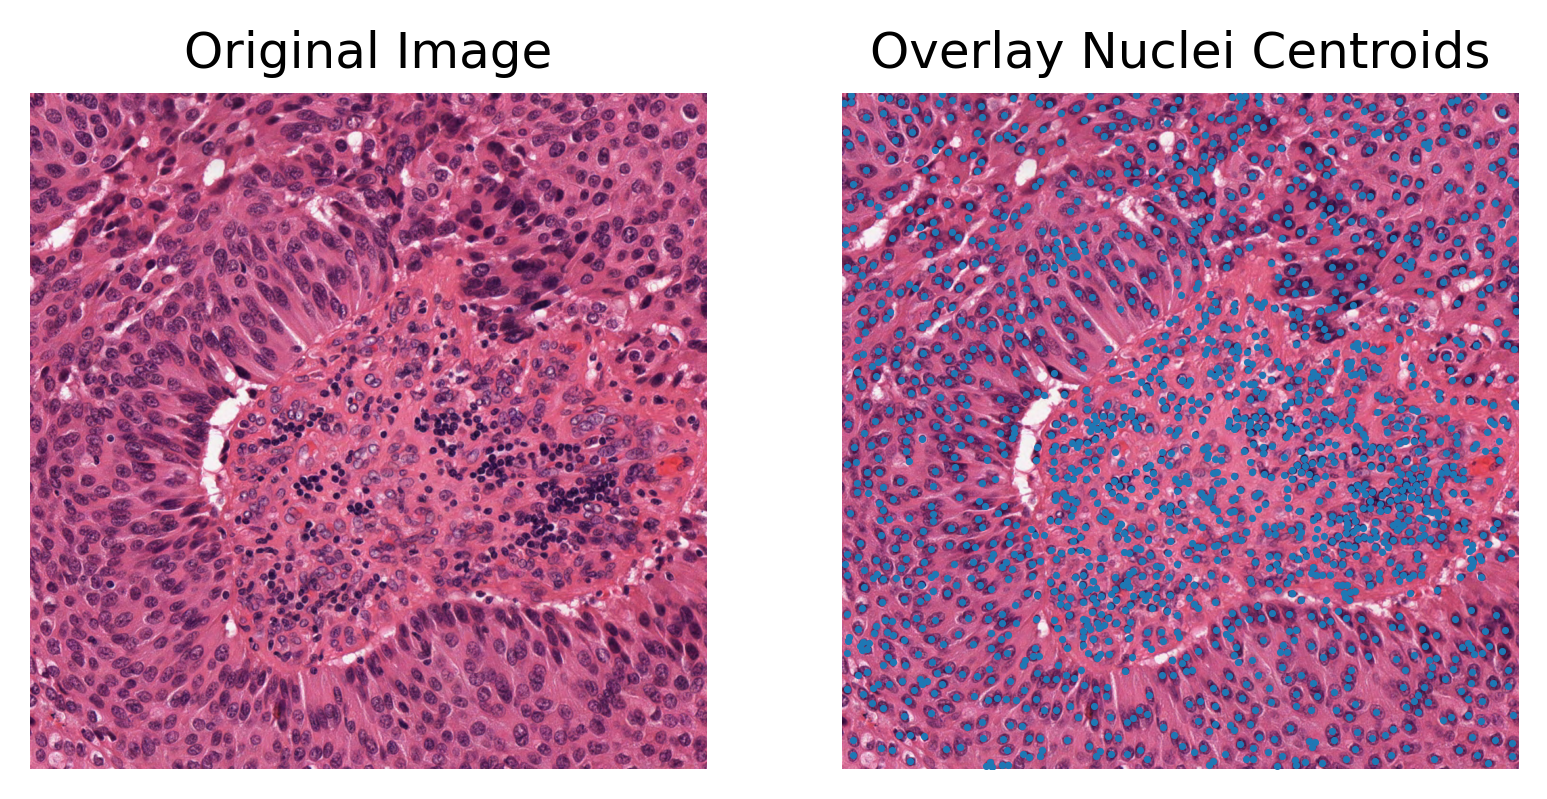

In [34]:
input_img = imread(img_file_name)
plt.subplot(1,2,1)
plt.imshow(input_img)
plt.axis("off")
plt.title("Original Image")

# Overlay nuclei centroids on image and plot
# Use scatter to create A scatter plot of y vs. x with varying marker size and/or color.
plt.subplot(1,2,2)
plt.imshow(input_img)
plt.scatter(np.array(centroids_list)[:,0], np.array(centroids_list)[:, 1], s=0.5)
plt.axis("off")
plt.title("Overlay Nuclei Centroids")
plt.show()

## Patches Based on Point Annotations

As you can see in the above figure, each nucleus is **marked** with a blue dot.

To train a nucleus classifier computer program (or a beginning pathologist), it is helpful to see a nucleus in context, that is, within a surrounding patch.

Therefore, we **extract**, for each nucleus, **a patch centred on that nucleus**.

---
If the third column of our dataframe has been completed meaningfully (which is not the case in our example), it is then easy to save patches in different folders based on their biological significance or class=classification.

This can be done using functions from the Python classes defined in out module `patchextraction`.

(We are using both class=biological classification and class=Python class for coding)

`patch_extractor` yields patch from the image, `input_img`, based on the `centroids_list` in a one-by-one manner. In the next code cell, we show how to use the function `get_patch_extractor` to obatain a suitable `patch_extractor`



In [22]:
patch_extractor = patchextraction.get_patch_extractor(
    input_img=input_img, # input image path, numpy array, or WSI object
    locations_list = np.array(centroids_list)[500:600, : ],  # path to list of points (csv, json), numpy list, panda DF
    method_name = "point", # also support "slidingwindow"
    patch_size = (32,32),  # size of the patch to extract around the centroids from centroids_list
    resolution = 0,
    units = "level"
)

As you can see, `patchextraction.get_patch_extractor` accepts several arguments:

* `input_img`: **The image from which we want to extract patches**. We can read the image and pass it to the function as a numpy array or instead, you can pass the path of the image file to the function.
* `locations_list`: **The list of points** at which the **required patches will be centred**. We load the points list as a panda data frame and pass it to the function or instead, you can pass to the function the path to a csv, npy or json file.
* `method_name`: This important argument specifies **the type of patch extractor** that we want to build. As we are looking to **extract patches around centroid points**, we use here the `point` option. Another option of `slidingwindow` is also supported.
* `patch_size`: Size of the patches.
* `resolution` and `unit` : Specify the level or micron-per-pixel resolution of the WSI. Here we specify the WSI's level 0. In general, this is the level of the **greatest resolution**, although, in this particular case, the image has only one level.

The `patch_extractor` yields information in small chunks, to avoid potential memory problems when the list of centroids is very long.

To extract patches using the `patch_extractor`, we use **for loop** as below, where we extract the first 16 patches specifed by `centroid_list`.

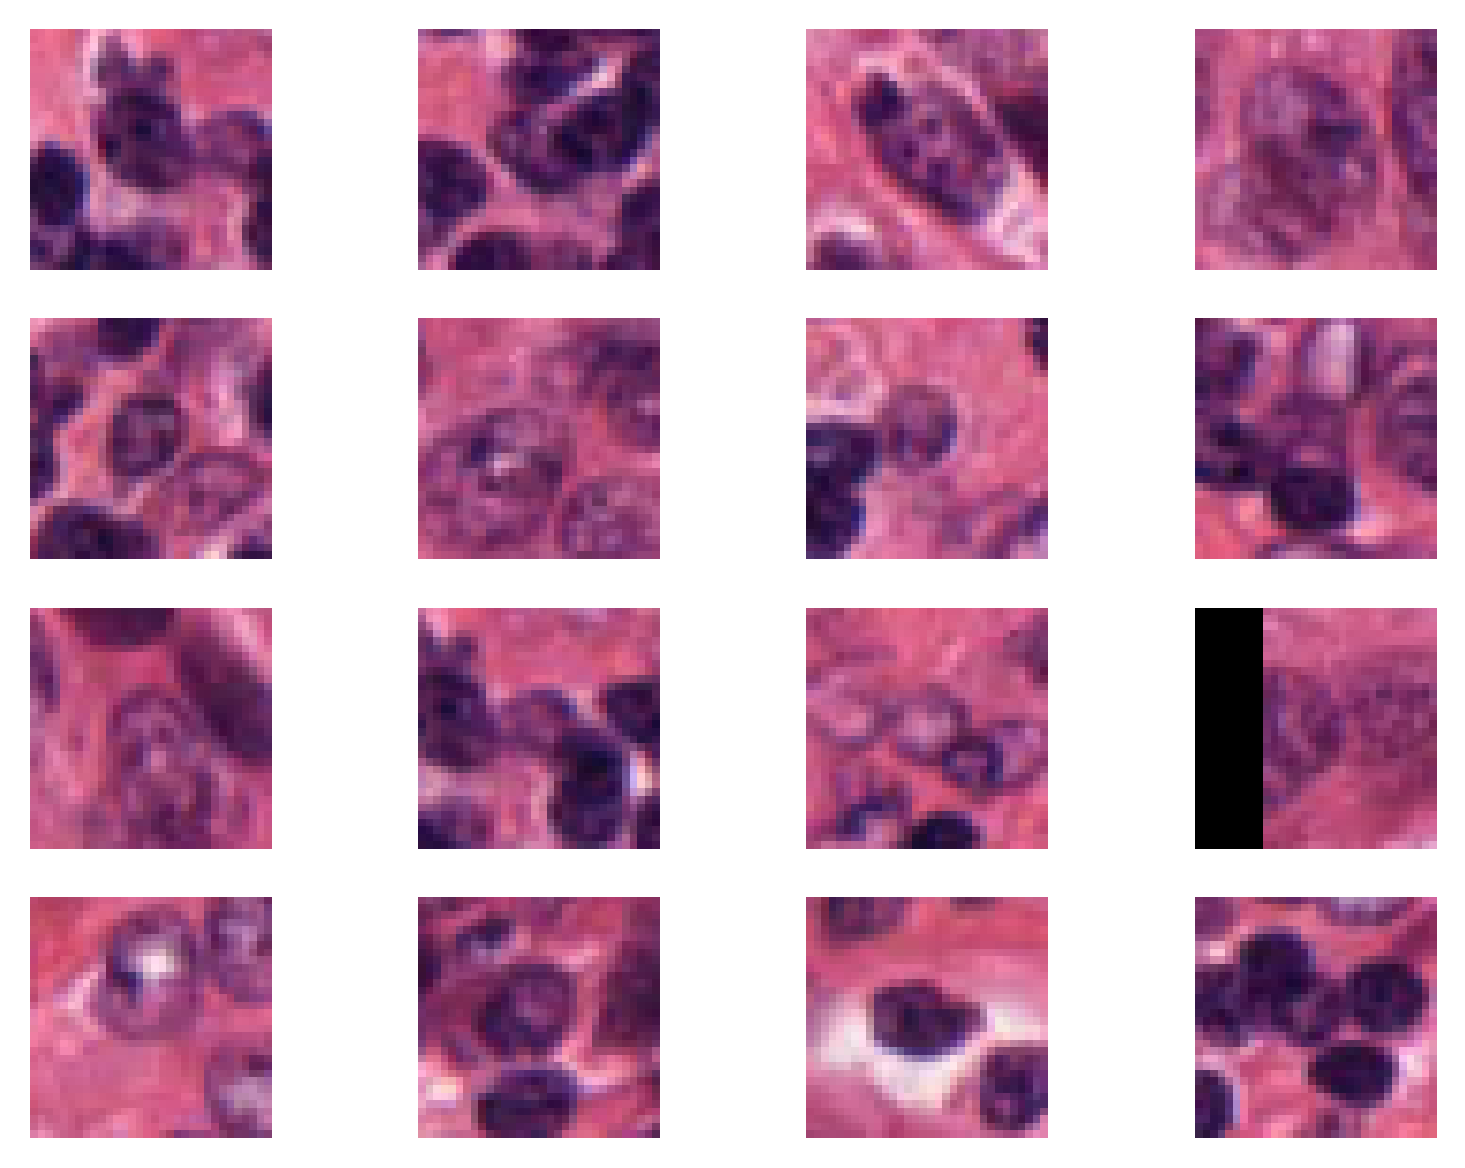

In [23]:
i = 1
for patch in patch_extractor:
  plt.subplot(4,4,i)
  plt.imshow(patch)
  plt.axis("off")
  if i >= 16: # show only first 16 patches
      break
  i += 1
plt.show()

Using the defined point `patch_extractor` we can extract a patch around a partical point in the dataFrame. For that, you just simply specify the index of the desired point for the `patch_extractor`.

For example, if we want to extract the patch around the 66th point in the dataFrame, we can do as below:

(-0.5, 31.5, 31.5, -0.5)

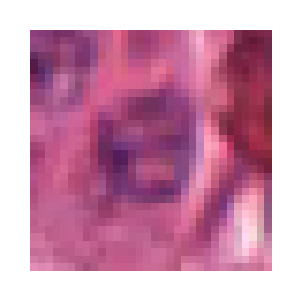

In [25]:
desired_patch = patch_extractor[66]

plt.subplot(4,4,1)
plt.imshow(desired_patch)
plt.axis("off")

## Generated fixed-size patches

A very common practice in computational pathology, when analysing large histology images or WSIs, is to **extract overlapping patches** from that image and **analyse them one by one**.

DL models often cannot accept large images due to memory limitations. We designed a tool in Tiatoolbox to ease the process of overlapping patch extraction for such goals.

The same `patchextraction` class supports another method that allows user to **extract all the patches** from the input image in an efficient way, using just one line of code.

In order to do that, one changes the method name in the `patchextraction` to `"slidingwindow"` as below:

`stirde`: Stride in (x, y) direction for patch extraction, default = patch_size.

In [30]:
fixed_patch_extractor = patchextraction.get_patch_extractor(
    input_img = input_img,
    method_name = "slidingwindow",
    patch_size = (500,500),  # size of the patch to extract around the centroids from centroids_list
    stride = (500,500) # stride of extracting patches, default is equal to patch_size
)

The `patchextraction` splits the input image into patches of size 500x500 without any overlap, beacuse the `stride` of patch extraction is the same as `patch_size`.

The `fixed_patch_extractor` is an iterator that **yields a patch** each time it is called.

As in the example above, we can use a **for** loop to access these patches:

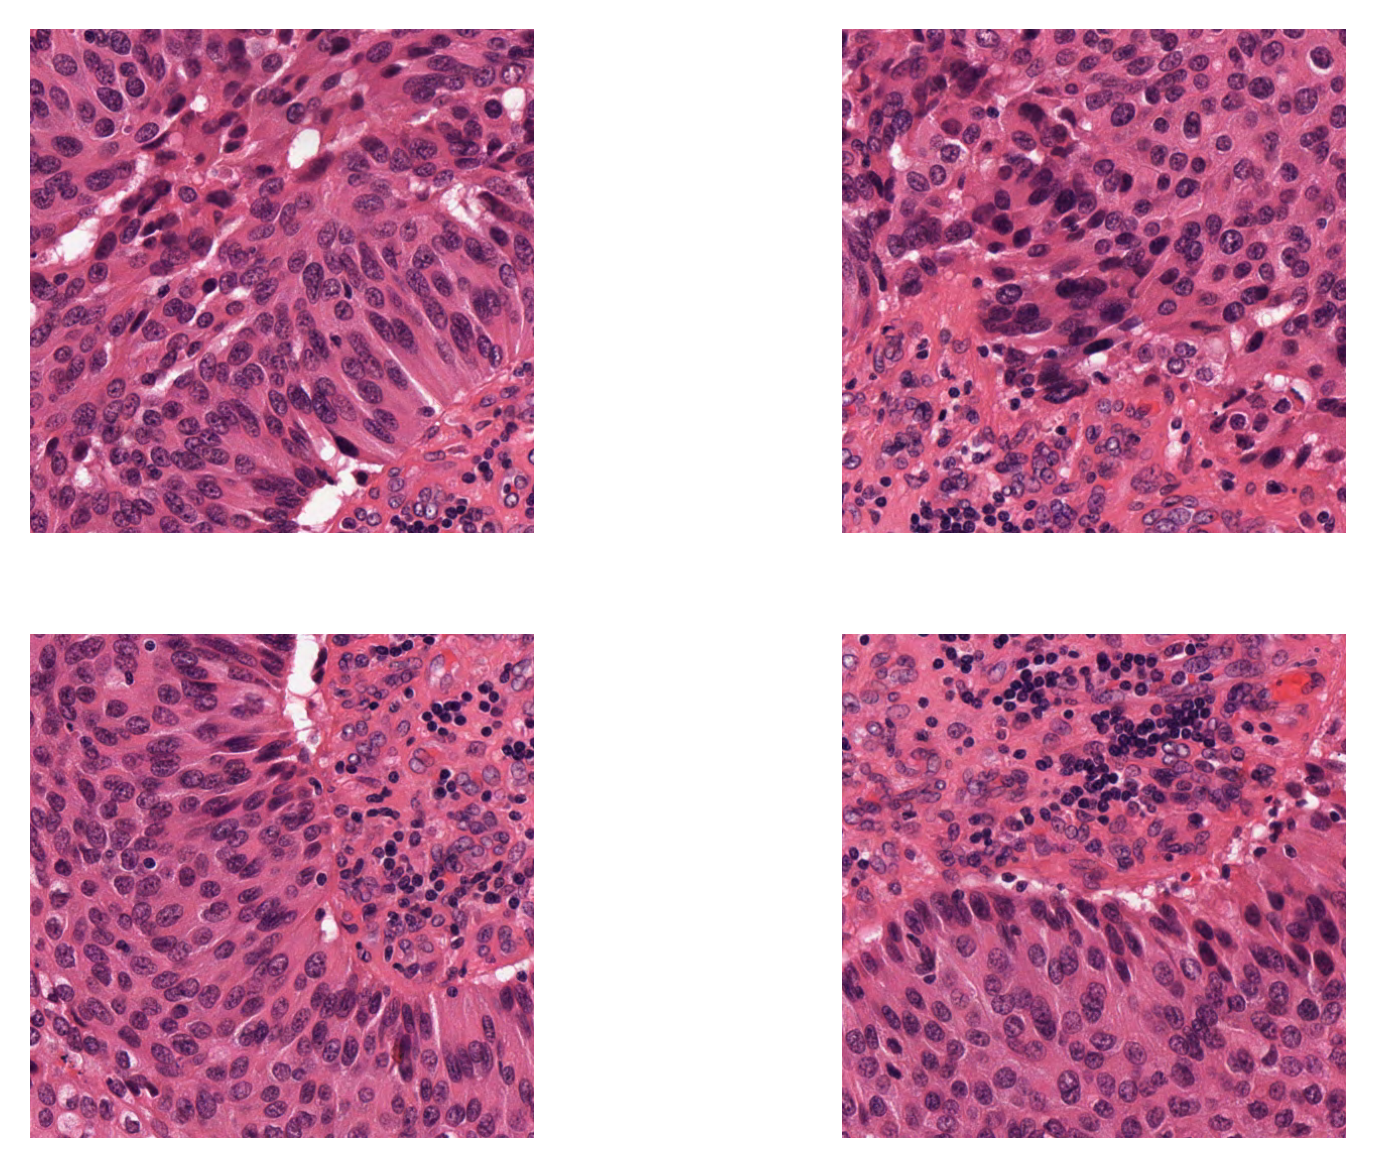

In [35]:
i = 1
for patch in fixed_patch_extractor:
  plt.subplot(2,2,i)
  plt.imshow(patch)
  plt.axis("off")
  i += 1
plt.show()

Otherwise, by setting the `stride` smaller than the 'patch_size', we can **extract overlapping patches**.

Below, we extract 500x500 patches that have **250 pixels overlap in both axes**.

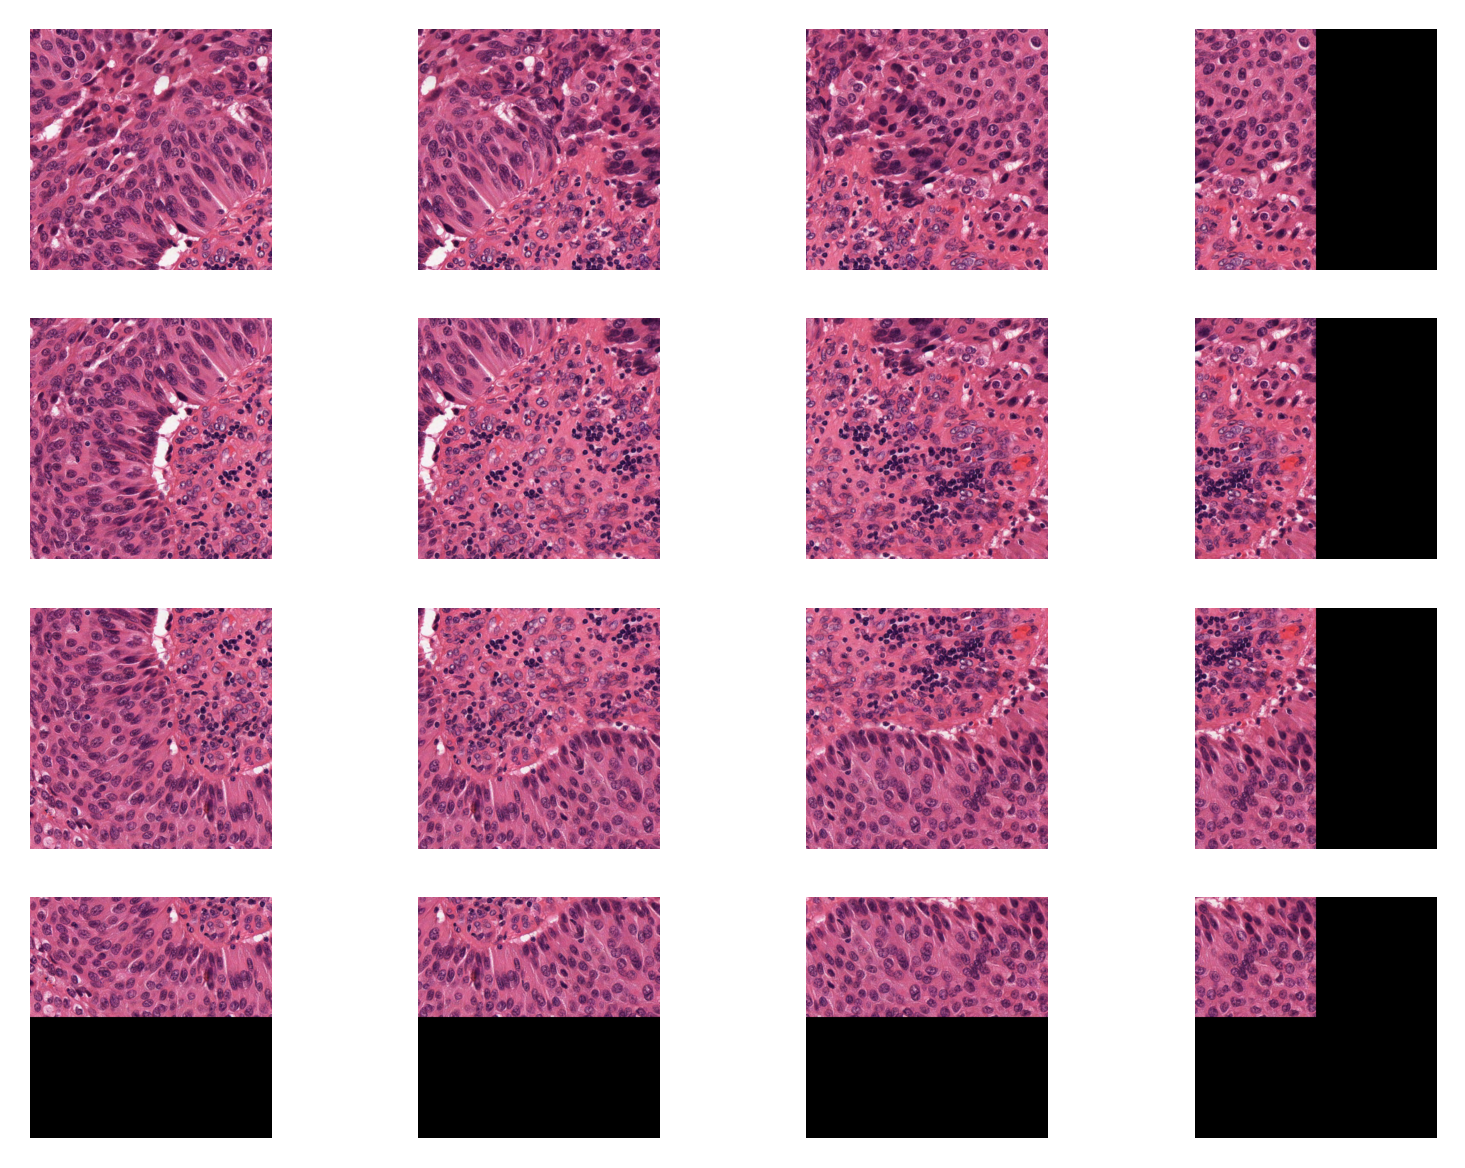

In [39]:
fixed_patch_extractor = patchextraction.get_patch_extractor(
    input_img = input_img,
    method_name = "slidingwindow",
    patch_size = (500,500),
    stride = (250,250) # 250 pixels overlap in both axes
)

i = 1
for patch in fixed_patch_extractor:
  plt.subplot(4,4,i)
  plt.imshow(patch)
  plt.axis("off")
  i += 1
plt.show()

Remember, you can always access a specific patch in your patch extractor using its index, as below:

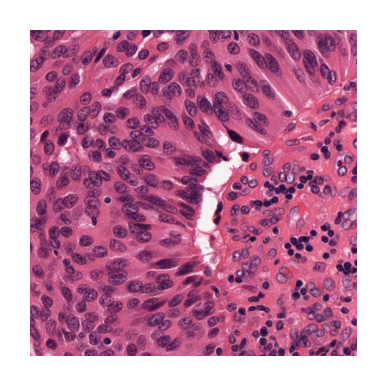

In [41]:
patch_idx = 4  # setting the patch index to point the fifth (middle) patch
this_path = fixed_patch_extractor[patch_idx]  # extracting the desired patch

# displaying the patch
plt.subplot(3, 3, 1)
plt.imshow(this_path)
plt.axis("off")
plt.show()

As you can see, the extracted patch is the same as the middle one in the above example.